# Импортируем данные

Бдуем исследовать цена на квартиры среднего качества,т. к. квартиры среднего качества покупает более широкий круг людей.

In [ ]:
import pandas as pd

df = pd.read_excel('avg_ptice_first.xlsx')
df.drop(['Все типы квартир','Квартиры улучшенного качества', 'Элитные квартиры'], axis=1, inplace=True)
df.set_index('Год')

,Квартиры среднего качества (типовые)
Год,
1998,4216.00
1999,5704.00
2000,7689.94
2001,9121.62
2002,11442.52
2003,14320.12
2004,18130.90
2005,22008.45
2006,32503.58


# Как найти порядок разности (d) в модели ARIMA

Нулевая гипотеза теста ADF заключается в том, что временной ряд нестационарен. Итак, если p-значение теста меньше уровня значимости (0,05), то вы отвергаете нулевую гипотезу и делаете вывод, что временной ряд действительно стационарный.

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['Квартиры среднего качества (типовые)'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 2.6995529977221344
p-value: 0.9990869955328704


Поскольку P-значение больше уровня значимости, давайте проведем различие рядов и посмотрим, как выглядит график автокорреляции.

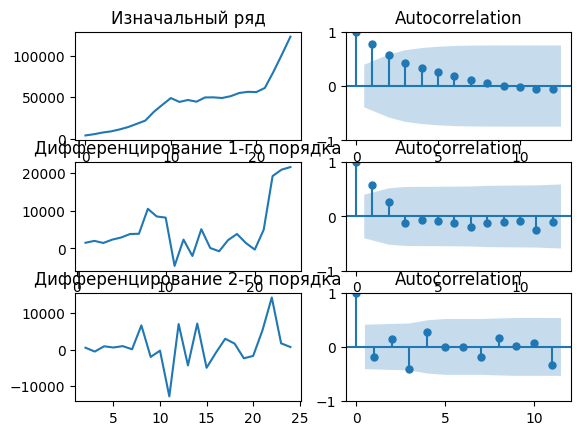

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt


# Изначальный ряд
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df['Квартиры среднего качества (типовые)'])
axes[0, 0].set_title('Изначальный ряд')
plot_acf(df['Квартиры среднего качества (типовые)'], ax=axes[0, 1])

# Дифференцирование 1-го порядка
axes[1, 0].plot(df['Квартиры среднего качества (типовые)'].diff());
axes[1, 0].set_title('Дифференцирование 1-го порядка')
plot_acf(df['Квартиры среднего качества (типовые)'].diff().dropna(), ax=axes[1, 1])

# Дифференцирование 2-го порядка
axes[2, 0].plot(df['Квартиры среднего качества (типовые)'].diff().diff())
axes[2, 0].set_title('Дифференцирование 2-го порядка')
plot_acf(df['Квартиры среднего качества (типовые)'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()


На графике автокорреляции второго порядка дифференцирования видно, что задержка почти сразу переходит в отрицательную сторону, это означает, что ряд может быть чрезмерно разнесен. Предварительно зафиксируем порядок разности равный 1, даже если ряд будет слабо стационарным.

In [ ]:
!pip install pmdarima
from pmdarima.arima.utils import ndiffs

## Adf Test
a = ndiffs(df['Квартиры среднего качества (типовые)'], test='adf')  # 1
print('ADF test', a)

# KPSS test
b = ndiffs(df['Квартиры среднего качества (типовые)'], test='kpss')  # 0
print('KPSS test', b)

# PP test:
c = ndiffs(df['Квартиры среднего качества (типовые)'], test='pp')  # 1
print('PP test', c)

ADF test 2
KPSS test 1
PP test 2


Исходя из результатов тестов:
ADF = 2: если ADF статистика равна 2, это означает, что p-value теста больше, чем уровень значимости. Это указывает на нестационарность временного ряда.
KPSS = 1: если KPSS статистика равна 1, это означает, что p-value теста меньше уровня значимости. Это говорит о том, что нулевая гипотеза о стационарности временного ряда отвергается, что также указывает на нестационарность ряда.
Исходя из результатов ADF и KPSS тестов, можно сделать вывод, что временной ряд скорее всего является нестационарным. Результат PP теста не позволяет однозначно сказать о наличии единичного корня.


# Как определить порядок членов AR (p)

Для определения членов AR воспользуемся графиком частичной автокорреляции (PACF). Построим график для дифференцирования первого порядка

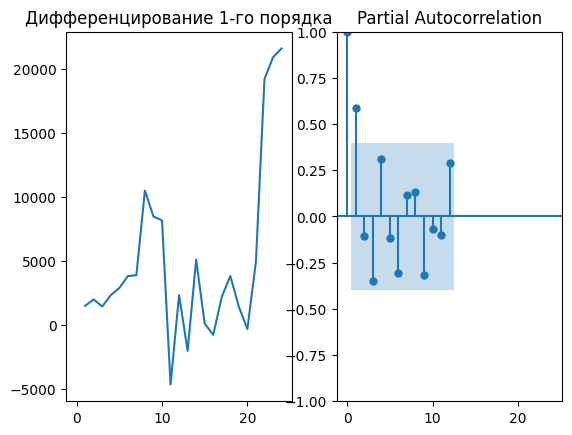

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['Квартиры среднего качества (типовые)'].diff()); axes[0].set_title('Дифференцирование 1-го порядка')
axes[1].set(ylim=(0,5))
plot_pacf(df['Квартиры среднего качества (типовые)'].diff().dropna(), ax=axes[1])

plt.show()

Можно заметить, что задержка PACF 1 довольно значительна, поскольку значительно превышает линию значимости (синяя область). Пусть значение p предварительно будет равно 1.

# Как определить порядок члена MA (q)

Для определения количества членов MA строим график ACF. ACF показывает, сколько членов MA требуется для удаления любой автокорреляции в стационарном ряду

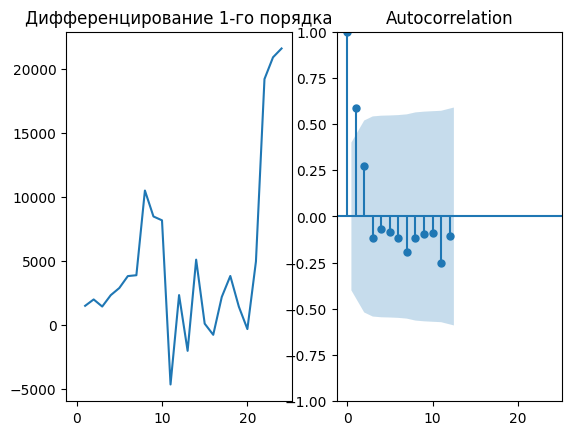

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['Квартиры среднего качества (типовые)'].diff())
axes[0].set_title('Дифференцирование 1-го порядка')
axes[1].set(ylim=(0,1.2))
plot_acf(df['Квартиры среднего качества (типовые)'].diff().dropna(), ax=axes[1])

plt.show()

Несколько задержек превышает линию значимости. Итак, предварительно исправим q = 2.


# Теперь можно переходить к построению модели ARIMA.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df['Квартиры среднего качества (типовые)'], order=(1, 1, 2))
arima_fit = arima_model.fit()
print(arima_fit.summary())


                                        SARIMAX Results                                         
Dep. Variable:     Квартиры среднего качества (типовые)   No. Observations:                   25
Model:                                   ARIMA(1, 1, 2)   Log Likelihood                -237.162
Date:                                  Thu, 15 Feb 2024   AIC                            482.324
Time:                                          12:32:16   BIC                            487.036
Sample:                                               0   HQIC                           483.574
                                                   - 25                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4316      0.460      0.938      0.348      -0.470

Исходя из результатов модели ARIMA (1,1,2) (Рис. 4) для квартир среднего качества, можно сделать следующие выводы:
1.	Коэффициенты авторегрессии (AR) и скользящего среднего (MA) не являются статистически значимыми на уровне значимости 0.05, так как p-значения больше уровня значимости.
2.	Тест Льюнга-Бокса не отвергает гипотезу о независимом распределении остатков модели на уровне значимости 0,05.
3.	Тест на гетероскедастичность показывает, что остатки модели не являются гомоскедастичными на уровне значимости 0,05.
Таким образом, модель ARIMA (1,1,2) может быть не самой оптимальной для прогнозирования квартир среднего качества, так как некоторые коэффициенты не являются статистически значимыми, и остатки модели не удовлетворяют некоторым предположениям. Попробуем улучшить качество модели с помощью автоматического прогноза ARIMA.


# Автоматический прогноз

In [ ]:
# !pip install pmdarima
import pmdarima as pm
auto_arima = pm.auto_arima(df['Квартиры среднего качества (типовые)'], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -234.284
Date:                Thu, 15 Feb 2024   AIC                            476.567
Time:                        09:53:53   BIC                            481.280
Sample:                             0   HQIC                           477.818
                                 - 25                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4937.1451   2471.824      1.997      0.046      92.460    9781.830
ma.L1          1.0526      0.203      5.197      0.000       0.656       1.450
ma.L2          0.9794      0.295      3.318      0.001       0.401       1.558
sigma2      1.493e+07      0.165   9.04e+07      0.000    1.49e+07    1.49e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.83   Prob(JB):                         0.86
Heteroskedasticity (H):               4.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.97e+24. Standard errors may be unstable.
"""

Исходя из полученной модели можно сделать следующие выводы:
1.	Коэффициенты скользящего среднего (MA) являются статистически значимыми на уровне значимости 0,05, так как p-значения меньше уровня значимости.
2.	Тест Льюнга-Бокса не отвергает гипотезу о независимом распределении остатков на уровне значимости 0,05.
Таким образом, модель ARIMA (0, 1, 2) может быть более подходящей для прогнозирования данного временного ряда, чем ARIMA(1, 1, 2), так как коэффициенты являются статистически значимыми, и остатки модели удовлетворяют предположениям о случайности. С помощью модели сделаем предсказания на 3 года вперед.


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_auto = ARIMA(df['Квартиры среднего качества (типовые)'], order=(0, 1, 2)).fit()
print(arima_auto.summary())

                                        SARIMAX Results                                         
Dep. Variable:     Квартиры среднего качества (типовые)   No. Observations:                   25
Model:                                   ARIMA(0, 1, 2)   Log Likelihood                -236.791
Date:                                  Thu, 15 Feb 2024   AIC                            479.581
Time:                                          09:53:53   BIC                            483.116
Sample:                                               0   HQIC                           480.519
                                                   - 25                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0873      0.208      5.239      0.000       0.681

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
n_steps = 3  # Количество шагов, на которые нужно сделать предсказания
forecast = arima_auto.forecast(steps=n_steps)

# Вывести предсказанные значения
print("Предсказанные значения:")
print(round(forecast, 2))

Предсказанные значения:
25    135029.48
26    141215.05
27    141215.05
Name: predicted_mean, dtype: float64


# Вторичный рынок

Правый столбец является индексом и является 2023, 2024 и 2025 годом соответственно.

In [ ]:
data = pd.read_excel('avg_price_second.xlsx')
df_1 = data[['Год','Квартиры среднего качества (типовые)']]
df_1

,Год,Квартиры среднего качества (типовые)
0,1998,4431.00
1,1999,5371.00
2,2000,6421.56
3,2001,8789.49
4,2002,11254.37
5,2003,13658.61
6,2004,17910.88
7,2005,21915.45
8,2006,36198.42
9,2007,44630.27


# Порядок разности d

Для определения порядка разности d, также воспользуемся тестом ADF.

In [ ]:
res = adfuller(df_1['Квартиры среднего качества (типовые)'].dropna())
print('ADF Статистика:', res[0])
print('p-value:', res[1])


ADF Статистика: -0.34214927756310043
p-value: 0.919318961289053


ADF статистика: -0.3421; p-value: 0.91932. P – значение вновь больше уровня значимости (0,05). Разделим ряды и посмотрим на графики автокорреляции

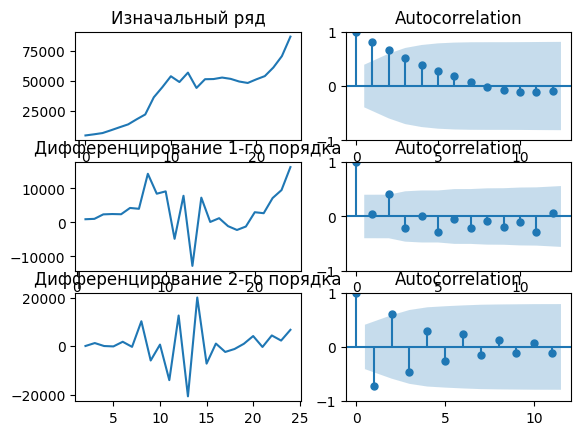

In [ ]:

# Изначальный ряд
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df_1['Квартиры среднего качества (типовые)'])
axes[0, 0].set_title('Изначальный ряд')
plot_acf(df_1['Квартиры среднего качества (типовые)'], ax=axes[0, 1])

# Дифференцирование 1-го порядка
axes[1, 0].plot(df_1['Квартиры среднего качества (типовые)'].diff());
axes[1, 0].set_title('Дифференцирование 1-го порядка')
plot_acf(df_1['Квартиры среднего качества (типовые)'].diff().dropna(), ax=axes[1, 1])

# Дифференцирование 2-го порядка
axes[2, 0].plot(df_1['Квартиры среднего качества (типовые)'].diff().diff())
axes[2, 0].set_title('Дифференцирование 2-го порядка')
plot_acf(df_1['Квартиры среднего качества (типовые)'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()


Для приведенных выше данных мы видим, что временные ряды достигают стационарности с двумя порядками различия. Предварительно d = 1.

# Определяем порядок членов AR (p)

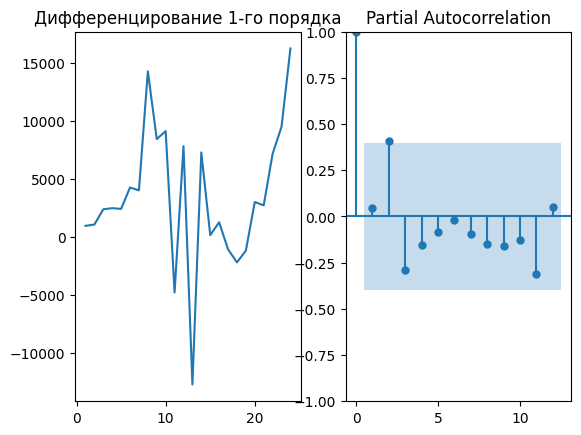

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df_1['Квартиры среднего качества (типовые)'].diff())
axes[0].set_title('Дифференцирование 1-го порядка')
axes[1].set(ylim=(0,5))
plot_pacf(df_1['Квартиры среднего качества (типовые)'].diff().dropna(), ax=axes[1])

plt.show()

Отставание PACF 1 довольно значительно, поскольку оно выше линии значимости. Зафиксируем значение p равным 1.


# Определяем порядок члена MA (q)

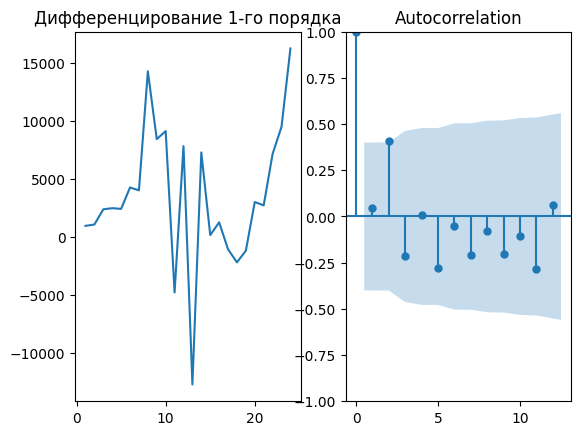

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df_1['Квартиры среднего качества (типовые)'].diff())
axes[0].set_title('Дифференцирование 1-го порядка')
axes[1].set(ylim=(0,1.2))
plot_acf(df_1['Квартиры среднего качества (типовые)'].diff().dropna(), ax=axes[1])

plt.show()

Из графика видно, что одна задержка превышает область значимости, предположим, что q = 1.

# Построение модели ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model_1 = ARIMA(df['Квартиры среднего качества (типовые)'], order=(1, 1, 1))
arima_fit_1 = arima_model_1.fit()
print(arima_fit_1.summary())


                                        SARIMAX Results                                         
Dep. Variable:     Квартиры среднего качества (типовые)   No. Observations:                   25
Model:                                   ARIMA(1, 1, 1)   Log Likelihood                -238.822
Date:                                  Thu, 15 Feb 2024   AIC                            483.645
Time:                                          09:53:55   BIC                            487.179
Sample:                                               0   HQIC                           484.582
                                                   - 25                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9816      0.219      4.490      0.000       0.553

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


По полученным результатам можно сделать следующие выводы:
1. Коэффициент авторегрессии (AR) равен 0.9816, что указывает на высокую корреляцию между текущим значением и предыдущим значением ряда.
2. Коэффициент скользящего среднего (MA) равен -0.1128, что может   указывать на наличие некоторой зависимости от ошибок предыдущих шагов.
3. Наличие гетероскедастичности указывает на неравномерное изменение дисперсии остатков.

Таким образом, модель ARIMA (1, 1, 1) может быть использована для прогнозирования квартир среднего качества, однако стоит учесть возможное наличие гетероскедастичности.

# Автоматическая подгонка модели ARIMA

In [ ]:
# !pip install pmdarima
import pmdarima as pm
auto_arima_1 = pm.auto_arima(df_1['Квартиры среднего качества (типовые)'], stepwise=False, seasonal=False)
auto_arima_1

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -239.291
Date:                Thu, 15 Feb 2024   AIC                            486.581
Time:                        09:54:00   BIC                            491.294
Sample:                             0   HQIC                           487.832
                                 - 25                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2968.4307   2533.188      1.172      0.241   -1996.527    7933.389
ma.L1          0.1743      0.193      0.902      0.367      -0.204       0.553
ma.L2          0.6108      0.258      2.367      0.018       0.105       1.117
sigma2      3.243e+07      0.040   8.09e+08      0.000    3.24e+07    3.24e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.94   Prob(JB):                         0.87
Heteroskedasticity (H):               1.56   Skew:                            -0.20
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+26. Standard errors may be unstable.
"""

Сравним модели с помощью информационного критерия AIC. AIC в модели ARIMA (1, 1, 1) равен 483,6, а в модели ARIMA (0, 1, 2) 486,6. Так как значение AIC у первой модели ниже, то первая модель больше подходит для прогнозирования цен.

In [ ]:
n_steps = 3  # Количество шагов, на которые нужно сделать предсказания
forecast_1 = arima_fit_1.forecast(steps=n_steps)

# Вывести предсказанные значения
print("Предсказанные значения:")
print(round(forecast_1, 2))

Предсказанные значения:
25    143951.08
26    164590.29
27    184849.76
Name: predicted_mean, dtype: float64
